# Introduction

Students who aspire to be software engineers probably already have spent four years of hard work earning their bachelor's degrees. It's a big decision whether they should go straight to the workforce or continue studying in school because of time and money. We want to investigate whether it is worth it to embark on a graduate education by looking at how much more or fewer workers who had a master's degree earned compared with workers who had a bachelor's degree in software engineering.

The problem we seek to answer: 

Does a master's degree come with a higher compensation (base salary + bonus + stock grants) in software engineering?

If we find significantly larger compensation for software engineers with a master degree than those without, we could then make the conclusion that two more years of educational experience is indeed worth the time and money.

#### The ideal experiment
- Random sampling: randomly select software engineers from a database of all STEM firms in the US region and calculate average compensation of those with and without a master degree. Our database only limit to workers from the top STEM companies.
- Control: When investigating factors that affect total compensation for software engineers, other confounding variables should be strictly controlled.  

## Import and Select the Data We Need

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1XrzzqHhuT2b9PNw3mS0TRixU1YXkidDy'
file = drive.CreateFile({'id':id}) 
file.GetContentFile('Levels_Fyi_Salary_Data.csv')

In [ ]:
import pandas as pd

df = pd.read_csv('Levels_Fyi_Salary_Data.csv')
df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,20000.0,10000.0,NaN,NaN,7392,807.0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,0.0,0.0,NaN,NaN,7419,807.0,2,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,0.0,0.0,NaN,NaN,11527,819.0,3,0,0,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,180000.0,35000.0,NaN,NaN,7472,807.0,7,0,0,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,0.0,0.0,NaN,NaN,7322,807.0,9,0,0,0,0,0,0,0,0,0,0,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62523 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   tag                      61788 non-null  object 
 9   basesalary               62642 non-null  float64
 10  stockgrantvalue          62642 non-null  float64
 11  bonus                    62642 non-null  float64
 12  gender                   43102 non-null  object 
 13  otherdetails             40137 non-null  object 
 14  cityid                

In [ ]:
round(df['Race'].isnull().sum()/df.shape[0]*100, 2)

64.2

In [ ]:
df['otherdetails'].nunique()

12841

In [ ]:
df['tag'].nunique()

3058

In [ ]:
df[df['tag'].notna()].head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
409,6/3/2018 13:58:20,Yahoo,IC2,Software Engineer,160500,"Sunnyvale, CA",0.58,0.58,Full Stack,128000.0,13000.0,19200.0,Male,NaN,7472,807.0,791,0,0,0,0,0,0,0,0,0,0,NaN,NaN
410,6/4/2018 0:16:01,Oracle,M3,Software Engineering Manager,340000,"Redwood City, CA",16.00,15.00,Distributed Systems (Back-End),206000.0,134000.0,0.0,Male,NaN,7392,807.0,794,0,0,0,0,0,0,0,0,0,0,NaN,NaN
411,6/4/2018 19:56:27,Qualcomm,Senior Staff Engineer,Software Engineer,240000,"Santa Clara, CA",15.00,6.00,Embedded Systems,0.0,0.0,0.0,Male,NaN,7434,807.0,797,0,0,0,0,0,0,0,0,0,0,NaN,NaN
412,6/4/2018 20:27:58,Splunk,P2,Software Engineer,160000,"Seattle, WA",5.00,3.00,Full Stack,0.0,0.0,0.0,Male,NaN,11527,819.0,798,0,0,0,0,0,0,0,0,0,0,NaN,NaN
413,6/5/2018 12:44:52,Google,L3,Software Engineer,208000,"Mountain View, CA",0.00,0.00,Distributed Systems (Back-End),116000.0,65000.0,17000.0,Male,40k signing,7322,807.0,805,0,0,0,0,0,0,0,0,0,0,NaN,NaN


- We drop the columns rowNumber, cityid and dmaid since we cannot extract effective information from those columns. 
- We drop the column Race because this columns contains too many missing values. (64.2% rows of this column are missing) and race info has been contained in other columns.
- The columns otherdetails and tag are descriptive text describing the specific employee of that row that do not contribute much effective information to the aggregration level of analysis.
- We drop the columns timestamp since we are not going to manipulate this dataset as Time Series data.

In [ ]:
drop_list = ['rowNumber', 'cityid', 'dmaid', 'Race', 'otherdetails', 'tag', 'timestamp']

data = df.drop(drop_list, axis = 1)
data.head()

,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Education
0,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,107000.0,20000.0,10000.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN
1,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN
2,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,155000.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN
3,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,157000.0,180000.0,35000.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN
4,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  62637 non-null  object 
 1   level                    62523 non-null  object 
 2   title                    62642 non-null  object 
 3   totalyearlycompensation  62642 non-null  int64  
 4   location                 62642 non-null  object 
 5   yearsofexperience        62642 non-null  float64
 6   yearsatcompany           62642 non-null  float64
 7   basesalary               62642 non-null  float64
 8   stockgrantvalue          62642 non-null  float64
 9   bonus                    62642 non-null  float64
 10  gender                   43102 non-null  object 
 11  Masters_Degree           62642 non-null  int64  
 12  Bachelors_Degree         62642 non-null  int64  
 13  Doctorate_Degree         62642 non-null  int64  
 14  Highschool            

# PART 1: Data Cleaning

## 1.1 Checking Missing Values

In [ ]:
data.isnull().sum()

company                        5
level                        119
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Education                  32272
dtype: int64

- 52% of the column Eduation are missing values. We just focus on the part of data that the Education values are not missing.

In [ ]:
data = data[data["Education"].notna()]
data.isnull().sum()

company                       2
level                        61
title                         0
totalyearlycompensation       0
location                      0
yearsofexperience             0
yearsatcompany                0
basesalary                    0
stockgrantvalue               0
bonus                         0
gender                     2604
Masters_Degree                0
Bachelors_Degree              0
Doctorate_Degree              0
Highschool                    0
Some_College                  0
Race_Asian                    0
Race_White                    0
Race_Two_Or_More              0
Race_Black                    0
Race_Hispanic                 0
Education                     0
dtype: int64

- There are still missing values in the column company, level, and gender. We just drop the rows that contain missing values in those columns.

In [ ]:
data = data.dropna(axis = 0)
data.isnull().sum()

company                    0
level                      0
title                      0
totalyearlycompensation    0
location                   0
yearsofexperience          0
yearsatcompany             0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
Masters_Degree             0
Bachelors_Degree           0
Doctorate_Degree           0
Highschool                 0
Some_College               0
Race_Asian                 0
Race_White                 0
Race_Two_Or_More           0
Race_Black                 0
Race_Hispanic              0
Education                  0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27709 entries, 3427 to 61991
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  27709 non-null  object 
 1   level                    27709 non-null  object 
 2   title                    27709 non-null  object 
 3   totalyearlycompensation  27709 non-null  int64  
 4   location                 27709 non-null  object 
 5   yearsofexperience        27709 non-null  float64
 6   yearsatcompany           27709 non-null  float64
 7   basesalary               27709 non-null  float64
 8   stockgrantvalue          27709 non-null  float64
 9   bonus                    27709 non-null  float64
 10  gender                   27709 non-null  object 
 11  Masters_Degree           27709 non-null  int64  
 12  Bachelors_Degree         27709 non-null  int64  
 13  Doctorate_Degree         27709 non-null  int64  
 14  Highschool         

After data cleaning, we now have 27709 rows data.

## 1.2 Checking Outliers

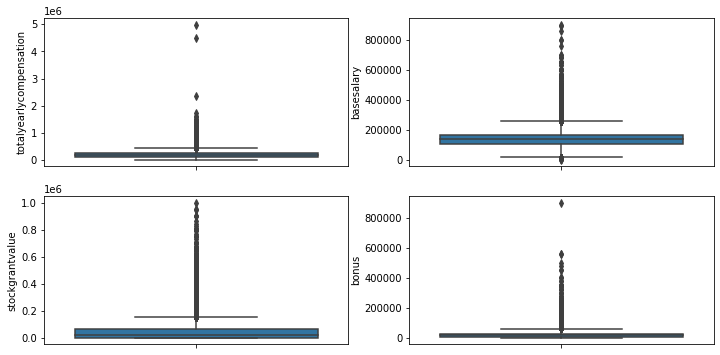

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (12, 6))

sns.boxplot(y = 'totalyearlycompensation', data = data, ax = ax[0, 0])
sns.boxplot(y = 'basesalary', data = data, ax = ax[0, 1])
sns.boxplot(y = 'stockgrantvalue', data = data, ax = ax[1, 0])
sns.boxplot(y = 'bonus', data = data, ax = ax[1, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

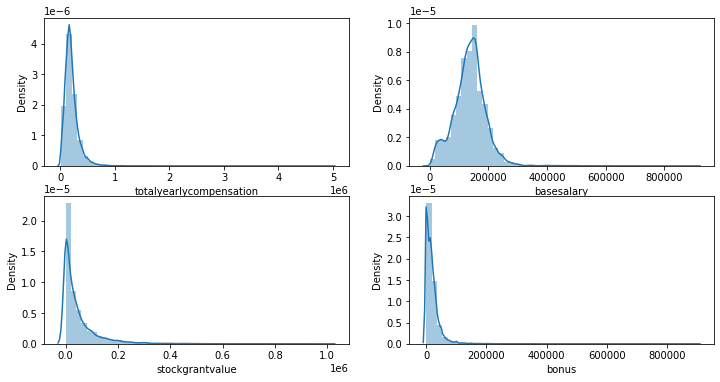

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (12, 6))

sns.distplot(data['totalyearlycompensation'], ax = ax[0, 0])
sns.distplot(data['basesalary'], ax = ax[0, 1])
sns.distplot(data['stockgrantvalue'], ax = ax[1, 0])
sns.distplot(data['bonus'], ax = ax[1, 1])

- For the four numerical columns in the dataset, which are total yearly compensation, base salary, stock grant value, and bonus, they all contain many outliers. (according to the boxplots)
- According to the histgrams, all those four columns are right-skewed and financial data are always right-skewed.

#PART 2: Descriptive Stats & Graphs

## 2.1 Descriptive Statistics

In [ ]:
data.describe()

,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic
count,2.770900e+04,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000,27709.000000
mean,2.039842e+05,7.174041,2.708938,136786.892345,47550.783680,18988.956657,0.496806,0.427839,0.055036,0.011152,0.012559,0.411058,0.276300,0.027608,0.023891,0.038471
std,1.330428e+05,5.808810,3.295441,56792.455623,74475.159929,25322.560798,0.499999,0.494774,0.228055,0.105013,0.111363,0.492035,0.447175,0.163851,0.152713,0.192334
min,1.000000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.240000e+05,3.000000,0.000000,105000.000000,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.800000e+05,6.000000,2.000000,138000.000000,22000.000000,14000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.500000e+05,10.000000,4.000000,165000.000000,60000.000000,26000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,4.980000e+06,45.000000,40.000000,900000.000000,1000000.000000,900000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.2 Graphs

In [ ]:
data.head()

,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Education
3427,Capital One,Senior Associate,Data Scientist,125000,"Washington, DC",1.0,0.0,121000.0,0.0,4000.0,Male,0,0,1,0,0,0,0,0,0,0,PhD
5037,Bloomberg,Software Engineer,Software Engineer,170000,"New York, NY",0.0,0.0,142000.0,0.0,18000.0,Male,1,0,0,0,0,0,0,0,0,0,Master's Degree
5392,Amazon,L5,Data Scientist,332000,"Palo Alto, CA",1.0,0.0,185000.0,17000.0,130000.0,Male,0,0,1,0,0,0,0,0,0,0,PhD
6055,Apple,ICT3,Software Engineer,240000,"Cupertino, CA",3.0,3.0,150000.0,75000.0,15000.0,Female,0,0,1,0,0,0,0,0,0,0,PhD
7218,Synopsys,100,Software Engineer,310000,"Mountain View, CA",25.0,9.0,210000.0,40000.0,60000.0,Male,0,0,1,0,0,0,0,0,0,0,PhD


Text(0.5, 1.0, 'Total Yearly Compensation')

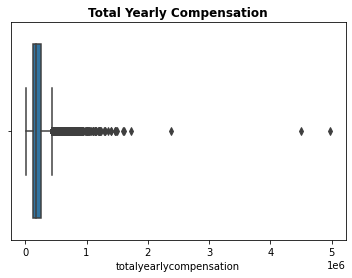

In [ ]:
sns.boxplot(x = 'totalyearlycompensation', data = data)
plt.title('Total Yearly Compensation',fontsize = 12, fontweight = 'bold')

Text(0.5, 1.0, 'Years of Experience')

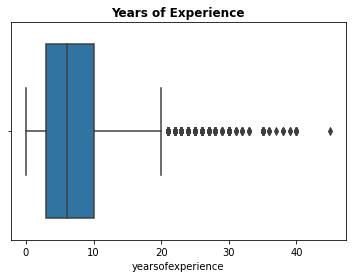

In [ ]:
sns.boxplot(x = 'yearsofexperience', data = data)
plt.title('Years of Experience',fontsize = 12, fontweight = 'bold')

Text(0.5, 1.0, 'Years At Company')

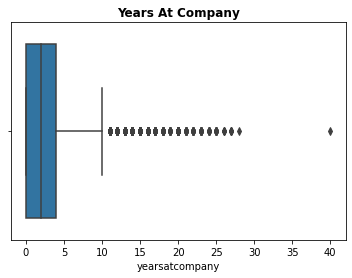

In [ ]:
sns.boxplot(x = 'yearsatcompany', data = data)
plt.title('Years At Company',fontsize = 12, fontweight = 'bold')

Text(0.5, 1.0, 'Base Salary')

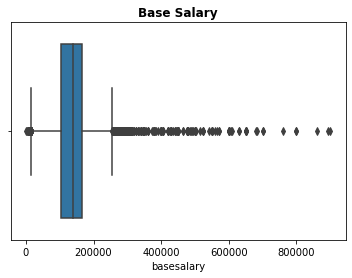

In [ ]:
sns.boxplot(x = 'basesalary', data = data)
plt.title('Base Salary',fontsize = 12, fontweight = 'bold')

Text(0.5, 1.0, 'Stock Grant Value')

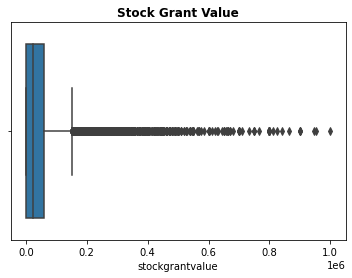

In [ ]:
sns.boxplot(x = 'stockgrantvalue', data = data)
plt.title('Stock Grant Value',fontsize = 12, fontweight = 'bold')

Text(0.5, 1.0, 'Bonus')

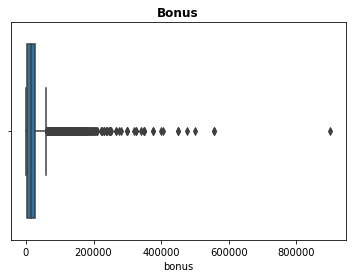

In [ ]:
sns.boxplot(x = 'bonus', data = data)
plt.title('Bonus',fontsize = 12, fontweight = 'bold')

Text(0.5, 1.0, 'Races')

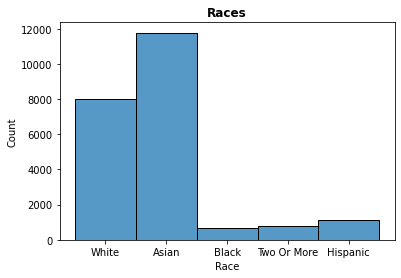

In [ ]:
sns.histplot(x = 'Race', data = df)
plt.title('Races',fontsize = 12, fontweight = 'bold')

In [ ]:
data['location'].value_counts()

Seattle, WA                3344
San Francisco, CA          2403
New York, NY               1986
Redmond, WA                1020
San Jose, CA                907
                           ... 
Boone, NC                     1
Canberra, CT, Australia       1
Hillsboro, OH                 1
Columbia, SC                  1
Chu-nan, TW, Taiwan           1
Name: location, Length: 825, dtype: int64

Text(0.5, 1.0, 'Company Name')

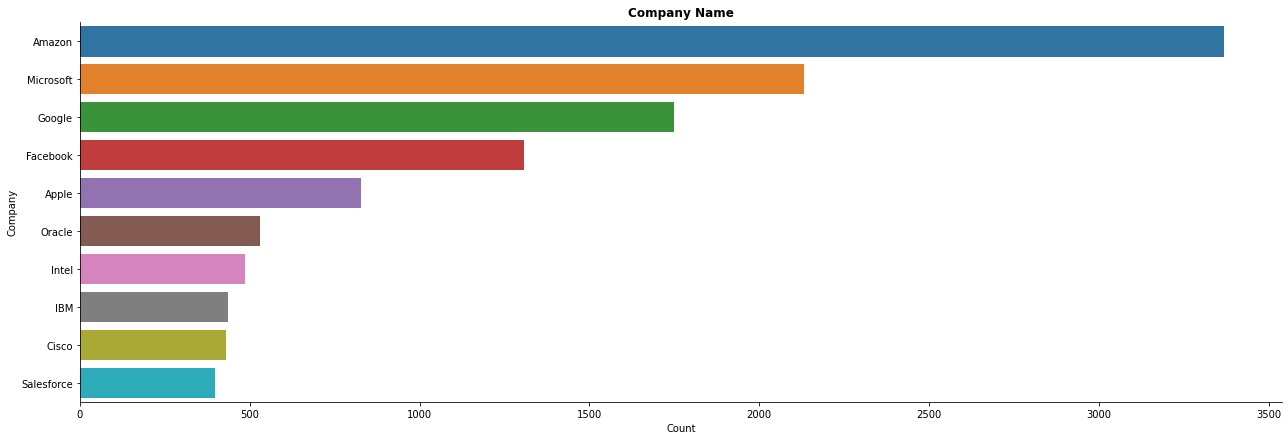

In [ ]:
company_name = data['company'].value_counts()[0:10].reset_index()
company_name.columns = ['Company', 'Count']
sns.catplot(x = 'Count', y = 'Company', kind = 'bar', data = company_name, height=6, aspect=3)
plt.title('Company Name',fontsize = 12, fontweight = 'bold')

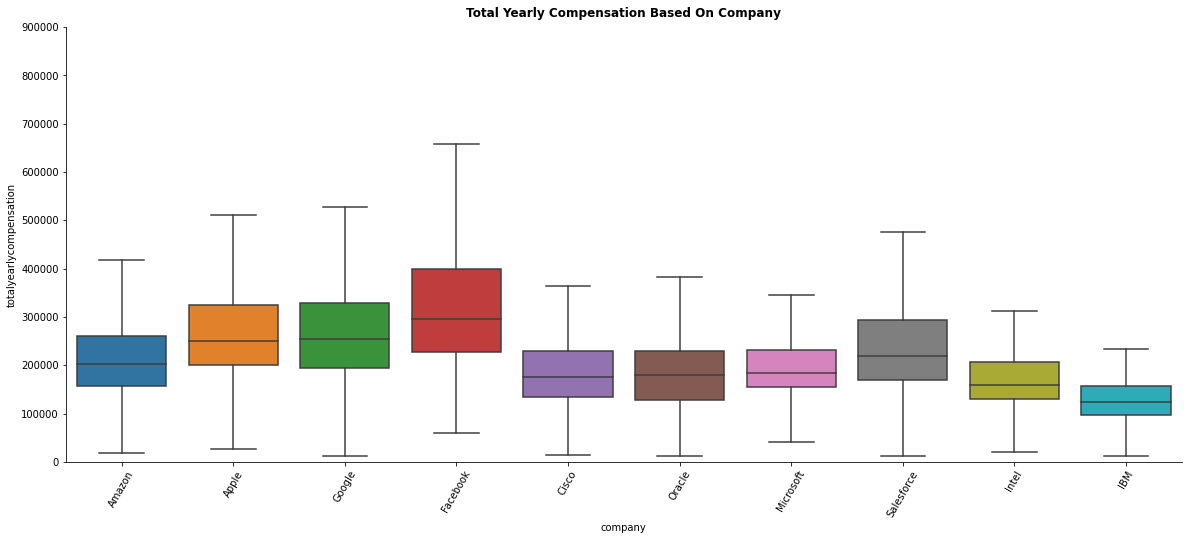

In [ ]:
data_company = data[(data['company'] == 'Amazon') | (data['company'] == 'Microsoft') | (data['company'] == 'Google')
       | (data['company'] == 'Facebook') | (data['company'] == 'Apple') | (data['company'] == 'Oracle') | (data['company'] == 'Intel') \
       | (data['company'] == 'IBM') | (data['company'] == 'Cisco') | (data['company'] == 'Salesforce')]

var = 'company'
f, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation=60)
plt.title('Total Yearly Compensation Based On Company',fontsize = 12, fontweight = 'bold', pad = 10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
fig = sns.boxplot(x=var, y="totalyearlycompensation", data=data_company, showfliers = False)
fig.axis(ymin=0, ymax=900000);

Text(0.5, 1.0, 'Job Title')

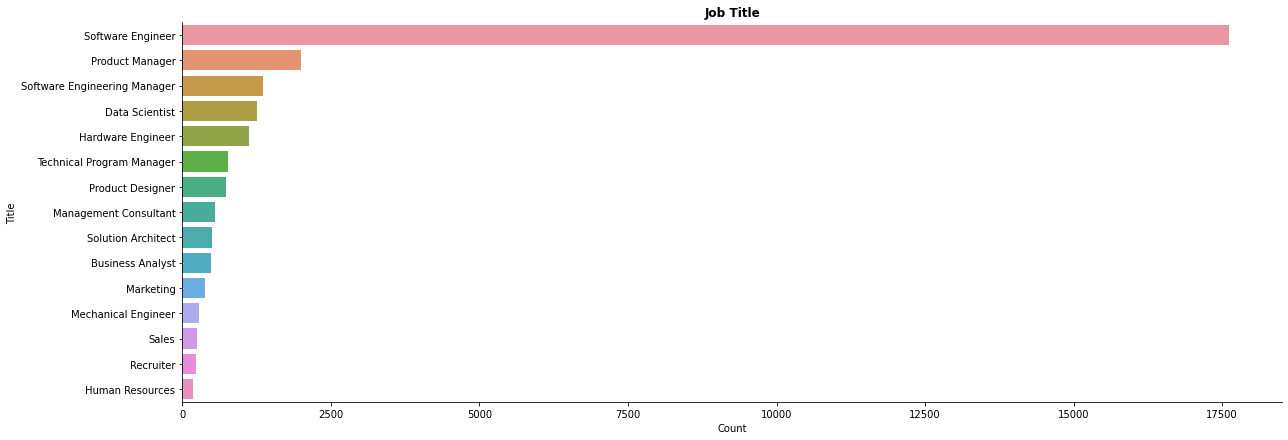

In [ ]:
titles = data['title'].value_counts().reset_index()
titles.columns = ['Title', 'Count']
sns.catplot(x = 'Count', y = 'Title', kind = 'bar', data = titles, height=6, aspect=3)
plt.title('Job Title',fontsize = 12, fontweight = 'bold')

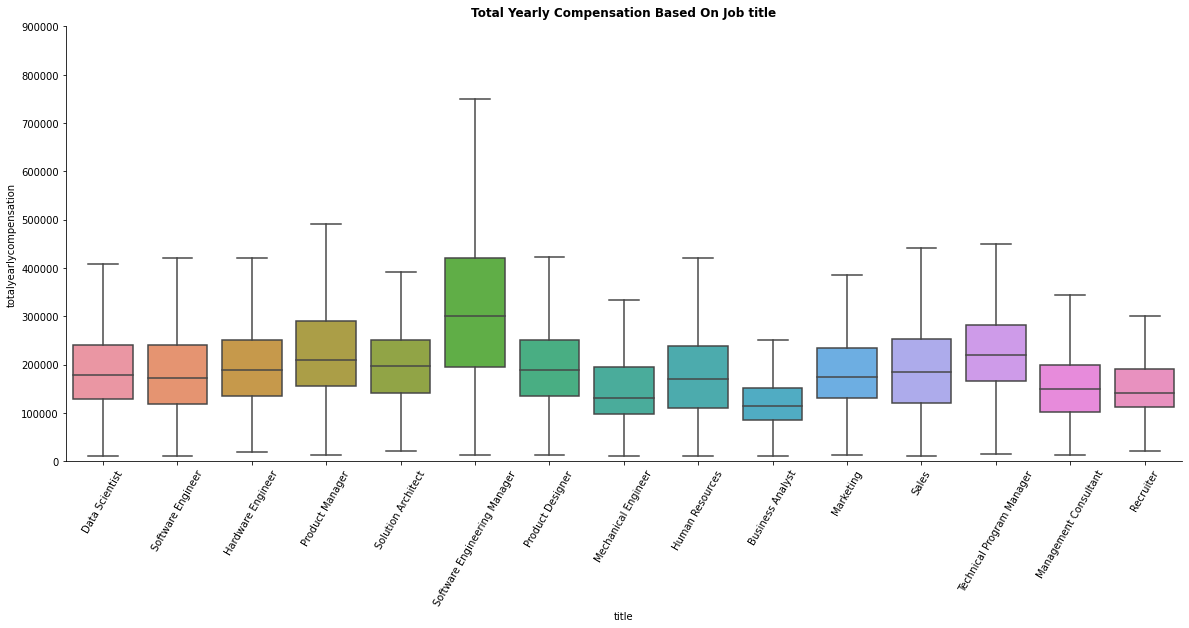

In [ ]:
var = 'title'
f, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation=60)
plt.title('Total Yearly Compensation Based On Job title',fontsize = 12, fontweight = 'bold', pad = 10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
fig = sns.boxplot(x=var, y="totalyearlycompensation", data=data, showfliers = False)
fig.axis(ymin=0, ymax=900000);

Text(0.5, 1.0, 'Location')

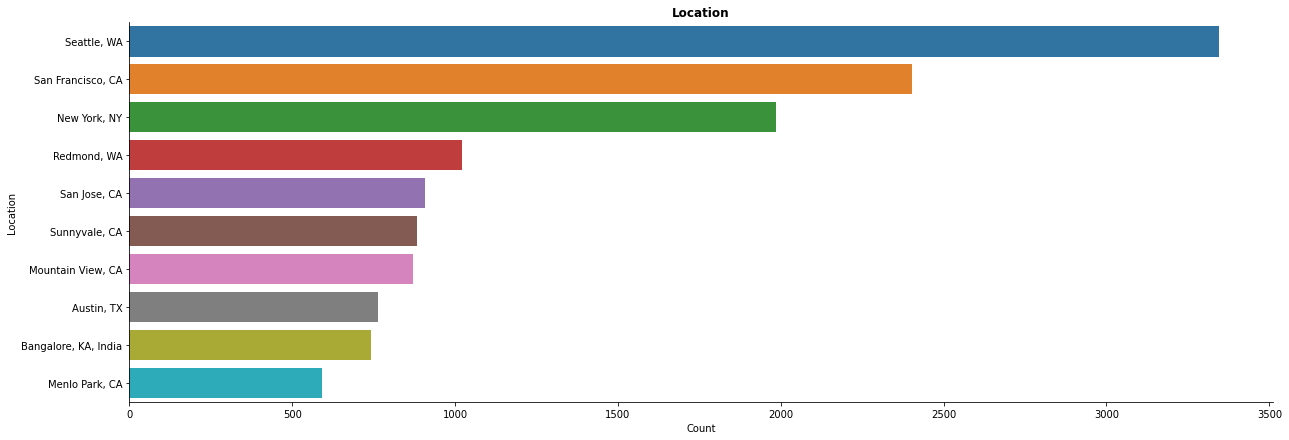

In [ ]:
locations = data['location'].value_counts()[0:10].reset_index()
locations.columns = ['Location', 'Count']
sns.catplot(x = 'Count', y = 'Location', kind = 'bar', data = locations, height=6, aspect=3)
plt.title('Location',fontsize = 12, fontweight = 'bold')

(-0.5, 8.5, 0.0, 900000.0)

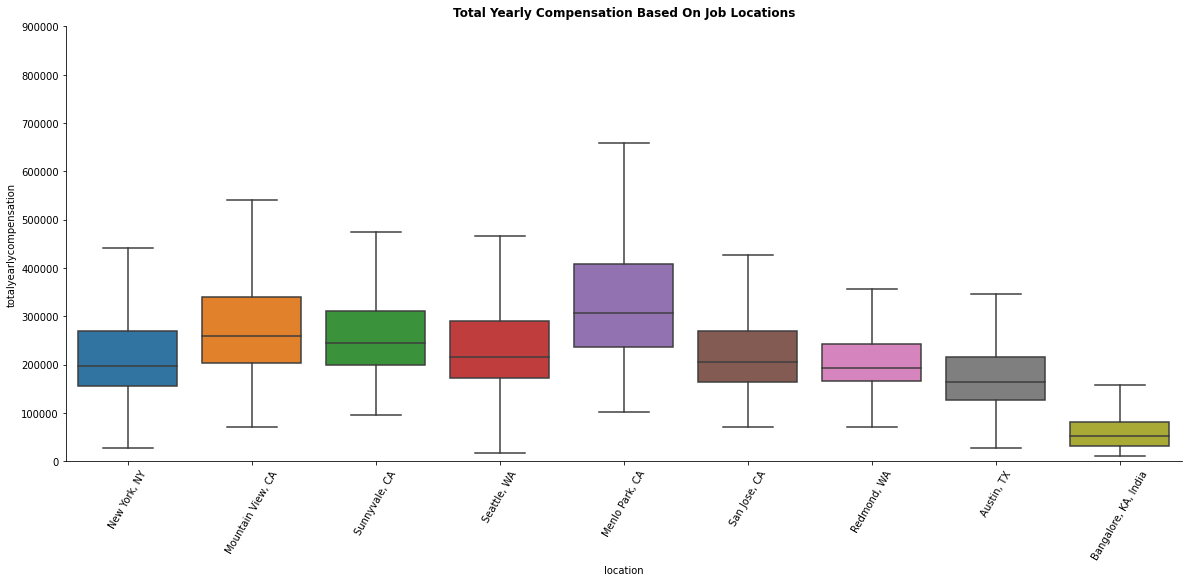

In [ ]:
data_company = data[(data['location'] == 'Seattle, WA') | (data['location'] == 'San Franciso, CA') | (data['location'] == 'New York, NY')
       | (data['location'] == 'Redmond, WA') | (data['location'] == 'San Jose, CA') | (data['location'] == 'Sunnyvale, CA') | (data['location'] == 'Mountain View, CA') \
       | (data['location'] == 'Austin, TX') | (data['location'] == 'Bangalore, KA, India') | (data['location'] == 'Menlo Park, CA')]

var = 'location'
f, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation=60)
plt.title('Total Yearly Compensation Based On Job Locations',fontsize = 12, fontweight = 'bold', pad = 10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
fig = sns.boxplot(x=var, y='totalyearlycompensation', data=data_company, showfliers = False)
fig.axis(ymin=0, ymax=900000)

Text(0.5, 1.0, 'Education Levels')

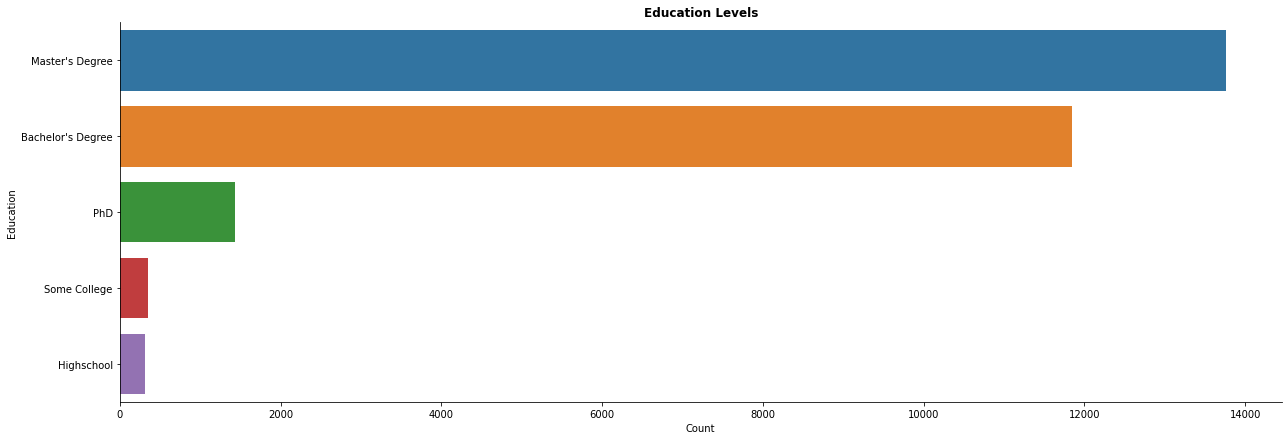

In [ ]:
education_levels = data['Education'].value_counts()[0:10].reset_index()
education_levels.columns = ['Education', 'Count']
sns.catplot(x = 'Count', y = 'Education', kind = 'bar', data = education_levels, height=6, aspect=3)
plt.title('Education Levels',fontsize = 12, fontweight = 'bold')


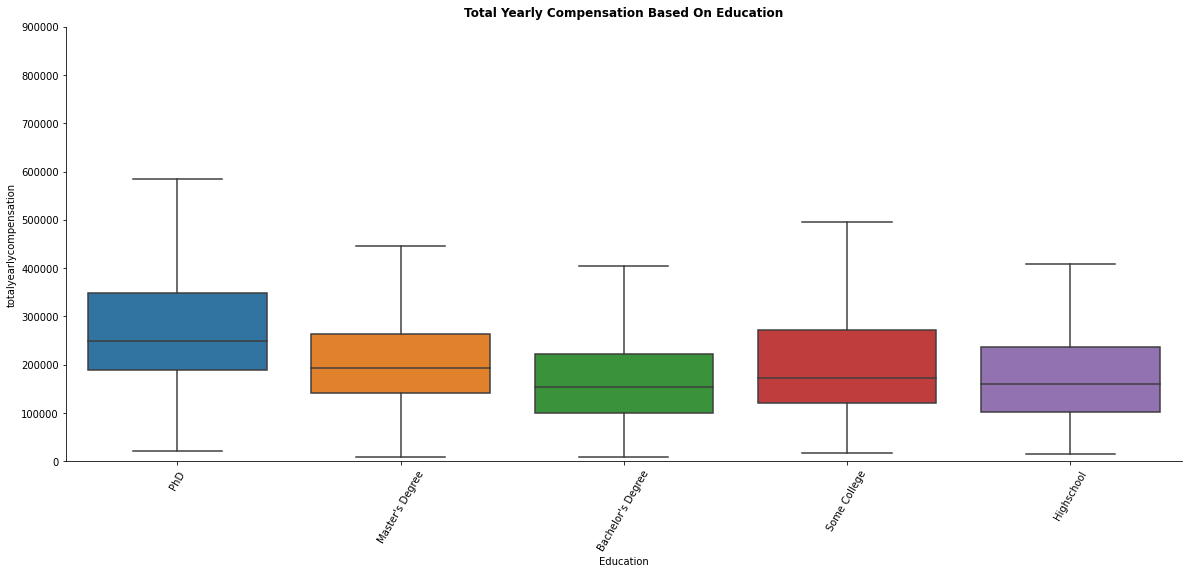

In [ ]:
var = 'Education'
f, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation=60)
plt.title('Total Yearly Compensation Based On Education',fontsize = 12, fontweight = 'bold', pad = 10)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
fig = sns.boxplot(x=var, y="totalyearlycompensation", data=data, showfliers = False)
fig.axis(ymin=0, ymax=900000);

#PART 3: Regression Analysis

##3.1 Scope of Investigation

In [ ]:
data.corr()

,totalyearlycompensation,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic
totalyearlycompensation,1.000000,0.401800,0.156748,0.787722,0.809306,0.531189,0.108452,-0.172704,0.153637,-0.015978,0.006196,-0.068055,0.011424,0.003220,-0.027017,-0.017907
yearsofexperience,0.401800,1.000000,0.527666,0.410647,0.291615,0.279652,0.100014,-0.112267,-0.007830,0.016047,0.059776,-0.089103,0.102546,-0.020140,-0.033330,-0.000825
yearsatcompany,0.156748,0.527666,1.000000,0.172806,0.098398,0.125802,0.044749,-0.045386,0.001468,-0.010227,0.009666,-0.046248,0.074241,-0.020810,-0.040828,-0.008469
basesalary,0.787722,0.410647,0.172806,1.000000,0.478092,0.398535,0.134904,-0.199604,0.150105,-0.016588,0.011265,-0.104162,0.034390,0.005131,-0.016433,-0.011372
stockgrantvalue,0.809306,0.291615,0.098398,0.478092,1.000000,0.255466,0.062244,-0.114782,0.127712,-0.011238,0.003805,-0.031835,-0.003930,0.001016,-0.038932,-0.019776
bonus,0.531189,0.279652,0.125802,0.398535,0.255466,1.000000,0.065812,-0.107913,0.101898,-0.010825,-0.000642,-0.032912,-0.003874,0.007058,-0.003796,-0.004685
Masters_Degree,0.108452,0.100014,0.044749,0.134904,0.062244,0.065812,1.000000,-0.858642,-0.211311,-0.105519,-0.112060,0.058736,-0.244635,-0.066105,-0.057611,-0.092545
Bachelors_Degree,-0.172704,-0.112267,-0.045386,-0.199604,-0.114782,-0.107913,-0.858642,1.000000,-0.208688,-0.091830,-0.097523,-0.011577,0.208218,0.063974,0.060552,0.087199
Doctorate_Degree,0.153637,-0.007830,0.001468,0.150105,0.127712,0.101898,-0.211311,-0.208688,1.000000,-0.025628,-0.027217,-0.049809,-0.017468,-0.017484,-0.024284,-0.014538
Highschool,-0.015978,0.016047,-0.010227,-0.016588,-0.011238,-0.010825,-0.105519,-0.091830,-0.025628,1.000000,-0.011976,-0.065669,0.095011,0.017764,0.005891,0.034152


The majority of our data is composed of software engineers. We will explore whether different job titles will have different yearly compensation distributions in respect of education levels. Then, we will decide whether to limit our investigation to only software engineers. 

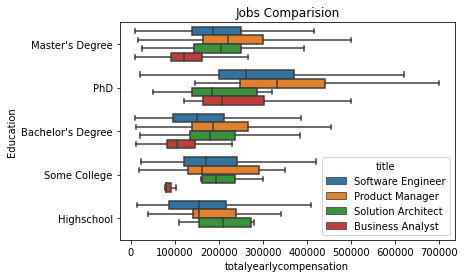

In [ ]:
top2bottom2_jobs = ["Software Engineer","Product Manager","Solution Architect","Business Analyst"]
data_4_jobs = data[data["title"].isin(top2bottom2_jobs)]
ax = sns.boxplot(x="totalyearlycompensation", y="Education", data=data_4_jobs, hue = "title", orient = "h", showfliers = False)
ax.set_title("Jobs Comparision")
plt.show()

We discovered an obvious difference is that for solution architects, people with high school degree and master degree have higher median total yearly compensation than people holding a PhD degree, which is deviant from other job salary pattern. Therefore, we believe job titles will have an effect on compensation among different education levels. We will limit our scope for regression analysis to just software engineers. 

In [ ]:
Software_engineer_data = data[data['title']=='Software Engineer']
Software_engineer_data.head()

,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Education
5037,Bloomberg,Software Engineer,Software Engineer,170000,"New York, NY",0.0,0.0,142000.0,0.0,18000.0,Male,1,0,0,0,0,0,0,0,0,0,Master's Degree
6055,Apple,ICT3,Software Engineer,240000,"Cupertino, CA",3.0,3.0,150000.0,75000.0,15000.0,Female,0,0,1,0,0,0,0,0,0,0,PhD
7218,Synopsys,100,Software Engineer,310000,"Mountain View, CA",25.0,9.0,210000.0,40000.0,60000.0,Male,0,0,1,0,0,0,0,0,0,0,PhD
7291,ExxonMobil,23,Software Engineer,105000,"Houston, TX",2.0,0.0,105000.0,0.0,5000.0,Male,1,0,0,0,0,0,0,0,0,0,Master's Degree
7758,Google,L3,Software Engineer,200000,"Sunnyvale, CA",0.0,0.0,143000.0,35000.0,22000.0,Female,0,0,1,0,0,0,0,0,0,0,PhD


In [ ]:
All = sm.ols(formula="totalyearlycompensation ~ yearsofexperience + yearsatcompany + gender + Education + Race_Asian + Race_White + Race_Black + Race_Hispanic + Race_Two_Or_More", 
                data=Software_engineer_data).fit()
print(All.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.195
Model:                                 OLS   Adj. R-squared:                  0.194
Method:                      Least Squares   F-statistic:                     327.8
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                             05:45:42   Log-Likelihood:            -2.2874e+05
No. Observations:                    17621   AIC:                         4.575e+05
Df Residuals:                        17607   BIC:                         4.576e+05
Df Model:                               13                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

When we include all potential independent variables in the regression analysis, we discovered 'Master's degree','PhD', 'yearsofexperience', 'yearsatcompany', 'Race_Asian', 'Race_White' are statistically significant in 5% significance level in deciding the total yearly compensation for software engineers. 

We would like to run two regression analysis to solve the two questions below:

1. Does a Master degree have a higher total yearly compensation for software engineers than a bachelor's degree? 

2. Does a Ph.D. degree have a higher total yearly compensation for software engineers than a master's degree? 

##3.2 Prepare Variables Data

We will include years of experience, years at company and race data for control. Our main independent variable is education level and dependent variable is total yearly compensation. 

In [ ]:
master_or_bachelor = Software_engineer_data[(Software_engineer_data["Education"] == "Master's Degree") | (Software_engineer_data["Education"] == "Bachelor's Degree")].loc[:,['totalyearlycompensation','yearsofexperience','yearsatcompany','Education','Race_Asian','Race_White']]
master_or_bachelor["master_or_bachelor_dm"] = [1 if x == "Master's Degree" else 0 for x in master_or_bachelor["Education"]]
master_or_bachelor.head()

,totalyearlycompensation,yearsofexperience,yearsatcompany,Education,Race_Asian,Race_White,master_or_bachelor_dm
5037,170000,0.0,0.0,Master's Degree,0,0,1
7291,105000,2.0,0.0,Master's Degree,0,0,1
12504,242000,8.0,1.0,Master's Degree,0,0,1
12506,172000,5.0,0.0,Master's Degree,0,0,1
12510,255000,5.0,0.0,Master's Degree,0,0,1


In [ ]:
phd_or_master = Software_engineer_data[(Software_engineer_data["Education"] == "Master's Degree") | (Software_engineer_data["Education"] == "PhD")].loc[:,['totalyearlycompensation','yearsofexperience','yearsatcompany','Education','Race_Asian','Race_White']]
phd_or_master["phd_or_master_dm"] = [1 if x == "PhD" else 0 for x in phd_or_master["Education"]]
phd_or_master.head()

,totalyearlycompensation,yearsofexperience,yearsatcompany,Education,Race_Asian,Race_White,phd_or_master_dm
5037,170000,0.0,0.0,Master's Degree,0,0,0
6055,240000,3.0,3.0,PhD,0,0,1
7218,310000,25.0,9.0,PhD,0,0,1
7291,105000,2.0,0.0,Master's Degree,0,0,0
7758,200000,0.0,0.0,PhD,0,0,1


##3.3 Regression Analysis

After the descriptive analysis, we are going to use regression analysis to address the two questions mentioned above. So far we have some insights into it but we do not know if this holds for the entire population. We can see if the results can be extended by performing a hypothesis test.

For the first question: Does a Master degree have a higher total yearly compensation for software engineers than a bachelor's degree? 

H0: μ_ms ≤ μ_ba

H1: μ_ms＞μ_ba


In [ ]:
regression1 = sm.ols(formula="totalyearlycompensation ~ yearsofexperience + yearsatcompany + Race_Asian + Race_White + master_or_bachelor_dm", 
                data=master_or_bachelor).fit()
print(regression1.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.168
Model:                                 OLS   Adj. R-squared:                  0.168
Method:                      Least Squares   F-statistic:                     662.5
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                             05:45:46   Log-Likelihood:            -2.1296e+05
No. Observations:                    16431   AIC:                         4.259e+05
Df Residuals:                        16425   BIC:                         4.260e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
regression1.params

Intercept                135716.083901
yearsofexperience          8793.483604
yearsatcompany            -2884.011358
Race_Asian               -15952.317226
Race_White                -5256.249206
master_or_bachelor_dm     30510.101751
dtype: float64

The coefficient of master_or_bachelor_dm is 30510.101751, and its p-value is 0.000 which is statistically significant at a 5% significance level.
It means that being a master rather than a bachelor will earn 30510 more dollars on a software engineering role, controlling for other variables.

We can reject null hypothesis and conclude that a Master degree have a higher total yearly compensation for software engineers than a bachelor's degree.

For the second question: Does a Ph.D. degree have a higher total yearly compensation for software engineers than a master's degree?

H0: μ_phd ≤ μ_ms

H1: μ_phd＞μ_ms

In [ ]:
regression2 = sm.ols(formula="totalyearlycompensation ~ yearsofexperience + yearsatcompany + Race_Asian + Race_White + phd_or_master_dm", 
                data=phd_or_master).fit()
print(regression2.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.179
Model:                                 OLS   Adj. R-squared:                  0.178
Method:                      Least Squares   F-statistic:                     392.4
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                             05:45:48   Log-Likelihood:            -1.1732e+05
No. Observations:                     9030   AIC:                         2.347e+05
Df Residuals:                         9024   BIC:                         2.347e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [ ]:
regression2.params

Intercept            166191.584876
yearsofexperience      9219.765697
yearsatcompany        -3978.386655
Race_Asian            -8723.762517
Race_White           -29868.181457
phd_or_master_dm      93666.062530
dtype: float64

The coefficient of master_or_bachelor_dm is 93666.062530, and it is also statistically significant at a 5% significance level.
It means that being a phd rather than a master will earn even 93666 more dollars on a software engineering role, controlling for other variables. 

We can still reject null hypothesis and draw a conclusion that a Ph.D. degree have a higher total yearly compensation for software engineers than a master's degree.

According to the results of two regression analysis, we can learn that a master's degree come with a higher compensation in Software Engineering jobs compared with a bachelor's degree but not with a phD's degree. To some extent, higher level does lead to higher total yearly compensation.

### Interaction term investigation
Now that we know that a master degree increases total compensation in Software Engineer jobs, we want to further investigate whether other factors like gender and race would interact with this impact…

#### Interaction 1: compensation ~ master degree x gender
Does gender affect how much a master degree increases total compensation? i.e. whether there's a difference in total compensation for males with a master degree and for females with a master degree.

In [ ]:
master_or_bachelor = Software_engineer_data[(Software_engineer_data["Education"] == "Master's Degree") | (Software_engineer_data["Education"] == "Bachelor's Degree")].loc[:,['totalyearlycompensation','yearsofexperience','yearsatcompany','Education','Race_Asian','Race_White', 'Race_Black', 'Race_Hispanic', 'gender']]
master_or_bachelor["master_or_bachelor_dm"] = [1 if x == "Master's Degree" else 0 for x in master_or_bachelor["Education"]]

In [ ]:
regression1 = sm.ols(formula="totalyearlycompensation ~ master_or_bachelor_dm + gender + master_or_bachelor_dm * gender", 
                data=master_or_bachelor).fit()
print(regression1.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.032
Model:                                 OLS   Adj. R-squared:                  0.031
Method:                      Least Squares   F-statistic:                     107.8
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):          2.41e-112
Time:                             05:45:56   Log-Likelihood:            -2.1421e+05
No. Observations:                    16431   AIC:                         4.284e+05
Df Residuals:                        16425   BIC:                         4.285e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

The interaction term has a p-value greater than 0.05, indicating that gender does not affect how a master degree increases total compensation.

#### Interaction 2: compensation ~ master degree x race
Does race affect how much a master degree increases total compensation? i.e. whether there's a difference in total compensation for Asian / White / Black / Hispanic with a master degree.


In [ ]:
# master x race_asian
regression1 = sm.ols(formula="totalyearlycompensation ~ master_or_bachelor_dm + Race_Asian + master_or_bachelor_dm * Race_Asian", 
                data=master_or_bachelor).fit()
print(regression1.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.040
Model:                                 OLS   Adj. R-squared:                  0.040
Method:                      Least Squares   F-statistic:                     229.9
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):          3.89e-146
Time:                             05:46:01   Log-Likelihood:            -2.1413e+05
No. Observations:                    16431   AIC:                         4.283e+05
Df Residuals:                        16427   BIC:                         4.283e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

p_value < 0.05

On a 5% significance level, Asian Software engineers with a master degree have a significantly higher compensation than those who do not have a master degree.

In [ ]:
# master x race_White
regression1 = sm.ols(formula="totalyearlycompensation ~ master_or_bachelor_dm + Race_White + master_or_bachelor_dm * Race_White", 
                data=master_or_bachelor).fit()
print(regression1.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.038
Model:                                 OLS   Adj. R-squared:                  0.038
Method:                      Least Squares   F-statistic:                     219.2
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):          1.94e-139
Time:                             05:46:02   Log-Likelihood:            -2.1415e+05
No. Observations:                    16431   AIC:                         4.283e+05
Df Residuals:                        16427   BIC:                         4.283e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

p_value < 0.05

On a 5% significance level, White STEM workers with a master degree have a significantly higher compensation than those who do not have a master degree.

In [ ]:
# master x race_Black
regression1 = sm.ols(formula="totalyearlycompensation ~ master_or_bachelor_dm + Race_Black + master_or_bachelor_dm * Race_Black", 
                data=master_or_bachelor).fit()
print(regression1.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.031
Model:                                 OLS   Adj. R-squared:                  0.031
Method:                      Least Squares   F-statistic:                     173.9
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):          5.43e-111
Time:                             05:46:03   Log-Likelihood:            -2.1421e+05
No. Observations:                    16431   AIC:                         4.284e+05
Df Residuals:                        16427   BIC:                         4.285e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

p_value > 0.05

On a 5% significance level, Black STEM workers with a master degree does not have a significantly higher compensation than those who do not have a master degree.

In [ ]:
# master x race_Hispanic
regression1 = sm.ols(formula="totalyearlycompensation ~ master_or_bachelor_dm + Race_Hispanic + master_or_bachelor_dm * Race_Hispanic", 
                data=master_or_bachelor).fit()
print(regression1.summary())

                               OLS Regression Results                              
Dep. Variable:     totalyearlycompensation   R-squared:                       0.031
Model:                                 OLS   Adj. R-squared:                  0.030
Method:                      Least Squares   F-statistic:                     172.7
Date:                     Thu, 02 Dec 2021   Prob (F-statistic):          2.93e-110
Time:                             05:46:03   Log-Likelihood:            -2.1422e+05
No. Observations:                    16431   AIC:                         4.284e+05
Df Residuals:                        16427   BIC:                         4.285e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

p_value > 0.05

On a 5% significance level, Hispanic STEM workers with a master degree does not have a significantly higher compensation than those who do not have a master degree.

In conclusion, the regression suggests: for Asian/White software engineers, having a master degree significantly increases total compensation; whereas for Black/Hispanic software engineers, having a master degree does not seem to have a significant impact on total compensation.

# Conclusion

- Master vs Bachelor: Software Engineers with a Master degree will earn \$30510 more than those with only a Bachelor degree, controlling for other variables.
- Master vs Ph.D: Software Engineers with a Master degree will earn $93666 more than those with a Master degree, controlling for other variables.

A master's degree come with a higher compensation in Software Engineering jobs compared with a bachelor's degree but not with a phD's degree. 
Higher level of education does lead to higher total yearly compensation in workplaces, at least for Software Engineering roles.
